# FYS375 Modellering av solfanger
Gruppe 3 - Høst 2021

Likevektskrav:  
Innstrålt +- 32  
Ta =- 1.5  
Tintlet -= 1  
massestrøm =- 2% av maximal, eller +-1% av mean value

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [102]:
data = pd.read_csv("Måledata_mars_juli_2020.csv")
data.Time = pd.to_datetime(data.Time)
data

,Time,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
0,2020-03-01 00:01:00,0.0,0.4,15.6,107.0,23.6
1,2020-03-01 00:02:00,0.0,0.4,15.6,107.0,23.6
2,2020-03-01 00:03:00,0.0,0.4,15.6,107.0,23.6
3,2020-03-01 00:04:00,0.0,0.4,15.6,107.0,23.6
4,2020-03-01 00:05:00,0.0,0.4,15.6,107.0,23.6
...,...,...,...,...,...,...
220314,2020-07-31 23:55:00,-1.0,17.7,25.5,0.0,26.9
220315,2020-07-31 23:56:00,-1.0,17.8,25.5,0.0,26.9
220316,2020-07-31 23:57:00,-1.0,17.8,25.5,0.0,26.9
220317,2020-07-31 23:58:00,-1.0,17.8,25.5,0.0,26.9


In [82]:
data_irra = data[data["Irradiance (W/m2)"] > 790]

In [341]:
data_irra.head()

,Time,Irradiance (W/m2),Ambient Temperature (C),Inlet Temperature (C),Mass flow (g/s),Outlet Temperature (C)
12151,2020-03-09 10:32:00,851.0,6.7,26.0,0.0,23.75
12193,2020-03-09 11:14:00,828.0,6.7,26.4,0.0,23.95
12194,2020-03-09 11:15:00,872.0,6.8,26.3,0.0,23.95
12209,2020-03-09 11:30:00,909.0,7.2,25.6,0.0,23.85
12210,2020-03-09 11:31:00,804.0,7.4,25.6,0.0,23.85


In [128]:
np_data = data_irra.to_numpy()
np_data

array([[Timestamp('2020-03-09 10:32:00'), 851.0, 6.7, 26.0, 0.0, 23.75],
       [Timestamp('2020-03-09 11:14:00'), 828.0, 6.7, 26.4, 0.0, 23.95],
       [Timestamp('2020-03-09 11:15:00'), 872.0, 6.8, 26.3, 0.0, 23.95],
       ...,
       [Timestamp('2020-07-31 15:56:00'), 801.0, 24.8, 22.3, 345.0, 43.6],
       [Timestamp('2020-07-31 15:57:00'), 799.0, 25.1, 22.3, 352.0, 43.6],
       [Timestamp('2020-07-31 15:58:00'), 793.0, 25.4, 22.3, 350.0, 43.6]],
      dtype=object)

In [141]:
info = []
for i, (tid, irradiance, Ta, Ti, ms, To) in enumerate(np_data[15:]):
    if tid - np_data[i][0] == pd.Timedelta("15m"):
        # save all 15 minutes innside infomration
        info.append(np_data[i:i+15])

In [142]:
info = np.array(info)
info.shape

(11706, 15, 6)

## Sette opp kravene våres til steady-state

In [166]:
innenfor_krav = []

for intervall15min in info:
    ir_mean, Ta_mean, Ti_mean, _, To_mean = (np.mean(intervall15min[:,1:], axis=0))
    if (np.max(abs(ir_mean - intervall15min[:,1])) <= 32 and 
        np.max(abs(Ta_mean - intervall15min[:,2])) <= 1.5 and 
        np.max(abs(To_mean - intervall15min[:,5])) <= 1 and
        np.min(intervall15min[:,4]) >= 50):

        innenfor_krav.append(intervall15min)
innenfor_krav = np.array(innenfor_krav)

In [167]:
innenfor_krav.shape

(8529, 15, 6)

In [374]:
femtenmin_split = np.array(innenfor_krav[0:2])

for v in innenfor_krav[2:]:
    if not np.isin(v[:,0], femtenmin_split[:, :, 0]).any():
        #print("legger til")
        femtenmin_split = np.append(femtenmin_split, [v], axis=0)


In [375]:
femtenmin_split = femtenmin_split[1:]

In [376]:
femtenmin_split.shape

(652, 15, 6)

## Fjerne rare massestrømmer: mean $\pm$ 1std

In [377]:
snitt = np.mean(femtenmin_split[:, :, 4].flatten())
std = np.std(femtenmin_split[:, :, 4].flatten())

femtenmin_split = femtenmin_split[(abs(femtenmin_split[:,:,4] - snitt) /std <= 1).any(axis=1)]
print(f"snitt: {snitt:.2f}, std:{std:.2f}")

snitt: 374.29, std:42.89


In [379]:
femtenmin_split.shape

(586, 15, 6)

In [411]:
pd.DataFrame(femtenmin_split[250])

,0,1,2,3,4,5
0,2020-05-27 15:04:00,887.0,17.4,20.1,350.0,42.15
1,2020-05-27 15:05:00,883.0,17.6,20.1,350.0,42.10
2,2020-05-27 15:06:00,880.0,17.5,20.1,348.0,42.05
3,2020-05-27 15:07:00,879.0,17.7,20.1,347.0,42.10
4,2020-05-27 15:08:00,879.0,17.7,20.1,347.0,42.25
5,2020-05-27 15:09:00,875.0,17.8,20.1,345.0,42.25
6,2020-05-27 15:10:00,872.0,17.2,20.1,345.0,42.25
7,2020-05-27 15:11:00,869.0,16.8,20.1,344.0,42.25
8,2020-05-27 15:12:00,868.0,16.9,20.1,343.0,42.25
9,2020-05-27 15:13:00,866.0,17.4,20.1,342.0,42.25


In [412]:
pd.DataFrame(femtenmin_split[251])

,0,1,2,3,4,5
0,2020-05-27 15:19:00,855.0,17.7,20.1,335.0,41.95
1,2020-05-27 15:20:00,853.0,18.0,20.1,335.0,41.95
2,2020-05-27 15:21:00,850.0,18.1,20.1,334.0,42.05
3,2020-05-27 15:22:00,848.0,18.2,20.2,334.0,42.25
4,2020-05-27 15:23:00,846.0,18.2,20.1,332.0,42.25
5,2020-05-27 15:24:00,844.0,17.8,20.1,331.0,42.30
6,2020-05-27 15:25:00,841.0,17.6,20.2,330.0,42.30
7,2020-05-27 15:26:00,839.0,18.0,20.2,330.0,42.30
8,2020-05-27 15:27:00,837.0,18.2,20.2,330.0,42.30
9,2020-05-27 15:28:00,835.0,18.2,20.2,328.0,42.30


# Modellering

### Finne variabel (X) veridene for hvert momentanpunkt:   
(1) $\frac{T_i - T_a}{G_T}$  Tm2/W  

### Finne virkningsgrad ved å se max effekt og Q  
(2) $\eta = \frac{Q}{E_{max}}$


### Virkinggrad er da Q / max effekt  
Q er hvor mye effekt som har gått ned i å varme opp vannet. $Q = m * c * delta T$   [g/s * j/(kg * K) * K] =
[g/s * j/kg] = [g/s * j/g] = [j/s] = [W]

c = 4.183 j/g K  
(3) $Q = \dot{m} * c * \Delta T $ [W]

### Max effekt
Solfanger er 67,2 m2  
(4) $GA = G * A $  
Der A = 67.2 m2 og G = G



In [380]:
X = []
Q = []
GA = []
for i in femtenmin_split:
    ir_mean, Ta_mean, Ti_mean, m_s_mean, To_mean = np.mean(i[:, 1:], axis=0)
    
    # X formelen
    x = (Ti_mean - Ta_mean)/ir_mean 
    X.append(x)
    
    # Q formelen
    q = m_s_mean * 4.183 * (To_mean - Ti_mean)
    Q.append(q)
    
    # GA foremlen
    ga = ir_mean * 67.2
    GA.append(ga)

X = np.array(X)
Q = np.array(Q)
GA = np.array(GA)

n = Q/GA

In [329]:
GA[n<0.1]

array([80640., 80640., 80640.])

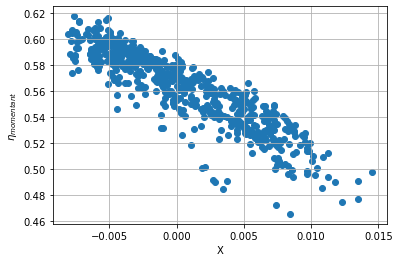

In [403]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.grid()
plt.xlabel("X")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [392]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))
reg.score(X[n>0.2].reshape(-1,1),n[n>0.2].reshape(-1,1))

0.7941282898548367

In [391]:
X.reshape(-1,1).shape

(586, 1)

In [393]:
pred = reg.predict(X[n>0.2].reshape(-1,1))

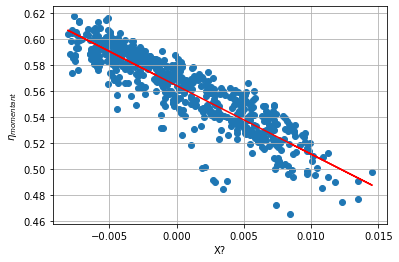

In [396]:
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="model")
plt.grid()
plt.xlabel("X?")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [401]:
print(f"b1: {reg.coef_}.. = Fr*Ul")

b1: [[-5.27614314]].. = Fr*Ul


In [404]:
print(f"b0: {reg.intercept_}.. = FR(τα)")

b0: [0.5642758].. = FR(τα)


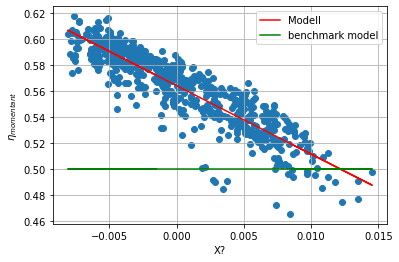

In [427]:
dårlig_prediksjon = [0.5 for i in range(584)]
plt.scatter(X[n>0.2],n[n>0.2])
plt.plot(X[n>0.2],pred, c="red", label="Modell")
plt.plot(X[n>0.2],dårlig_prediksjon, c="green", label="benchmark modell")
plt.grid()
plt.legend()
plt.xlabel("X?")
plt.ylabel("$\eta_{momentant}$")
plt.show()

In [425]:
from sklearn.metrics import mean_absolute_percentage_error
print(f"Lav er bra \n\
Dårlig model: {mean_absolute_percentage_error(n[n>0.2], dårlig_prediksjon):.3f} \n\
God modell: {mean_absolute_percentage_error(n[n>0.2], pred):.2f}")

Lav er bra 
Dårlig model: 0.108 
God modell: 0.02


## Noen andre plot
residualplot

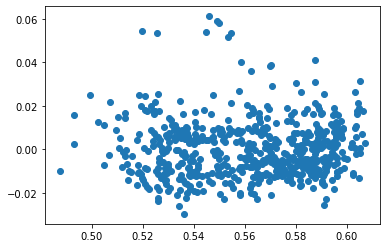

In [436]:
plt.scatter(pred, pred-n[n>0.2].reshape(-1,1))
plt.title("God modell")
plt.grid()
plt.xlabel("fitted values")
p

In [434]:
n[n>0.2].rehape(-1,1)

(584,)